<a href="https://colab.research.google.com/github/roesta07/Modeling-COVID-19/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.8
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz --no-dependencies
    !pip install netCDF4
    !pip install xarray


     |████████████████████████████████| 911kB 12.3MB/s 
     |████████████████████████████████| 1.5MB 31.6MB/s 
     |████████████████████████████████| 737kB 41.3MB/s 
     |████████████████████████████████| 4.7MB 47.2MB/s 
     |████████████████████████████████| 296kB 39.3MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
  Created wheel for daft: filename=daft-0.1.0-cp36-none-any.whl size=11375 sha256=cd3cf0b28a9ef65981bdbe6f19685eebd948febb692aaf4dffe7f423411bfae5
  Stored in directory: /root/.cache/pip/wheels/37/e9/8a/4186b68a6a3a042e0947b445ec6184e61b583bfad59af6fe49
Successfully built daft
  Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4
Requirement already up-to-date: theano in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [17]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
from theano import theano

sampler_kwargs={'chains':4,'cores':4,'return_inferencedata':True}

from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [5]:
## lets bring the who data
def load_covid_timeseries(name):
  base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
  url=f'{base_url}/time_series_covid19_{name}_global.csv'
  df=pd.read_csv(url,
                index_col=['Country/Region', 'Province/State', 'Lat', 'Long']) 
  df['type']=name.lower()
  df.columns.name='date'
  df=df.set_index('type',append=True).reset_index(['Lat','Long'],drop=True).stack().reset_index().set_index('date')
  df.index = pd.to_datetime(df.index)

  df.columns=['country', 'state', 'type', 'cases']
  df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
  df.loc[df.state =='Hong Kong', 'state'] = np.nan
  return df

def load_covid_data(type):
  df=load_covid_timeseries(type)
  df=df.rename(columns={'cases':type.lower()})
  df=days_after_100(df)
  return df

def days_after_100(df):
  df=df.loc[(df['confirmed']>100)]
  df.loc[:,'days_since_100']=np.nan
  for country in df.country.unique():
    filt=(df['country']==country)
    length=len(df.loc[filt,'days_since_100'].values)
    counter=np.arange(0,length)
    df.loc[filt,'days_since_100']=counter
  return df

In [6]:
df=load_covid_data('confirmed')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [7]:
df.head()

,country,state,type,confirmed,days_since_100
date,,,,,
2020-03-28,Afghanistan,NaN,confirmed,107,0.0
2020-03-29,Afghanistan,NaN,confirmed,118,1.0
2020-03-30,Afghanistan,NaN,confirmed,146,2.0
2020-03-31,Afghanistan,NaN,confirmed,175,3.0
2020-04-01,Afghanistan,NaN,confirmed,197,4.0


Text(0, 0.5, 'confirmed cases')

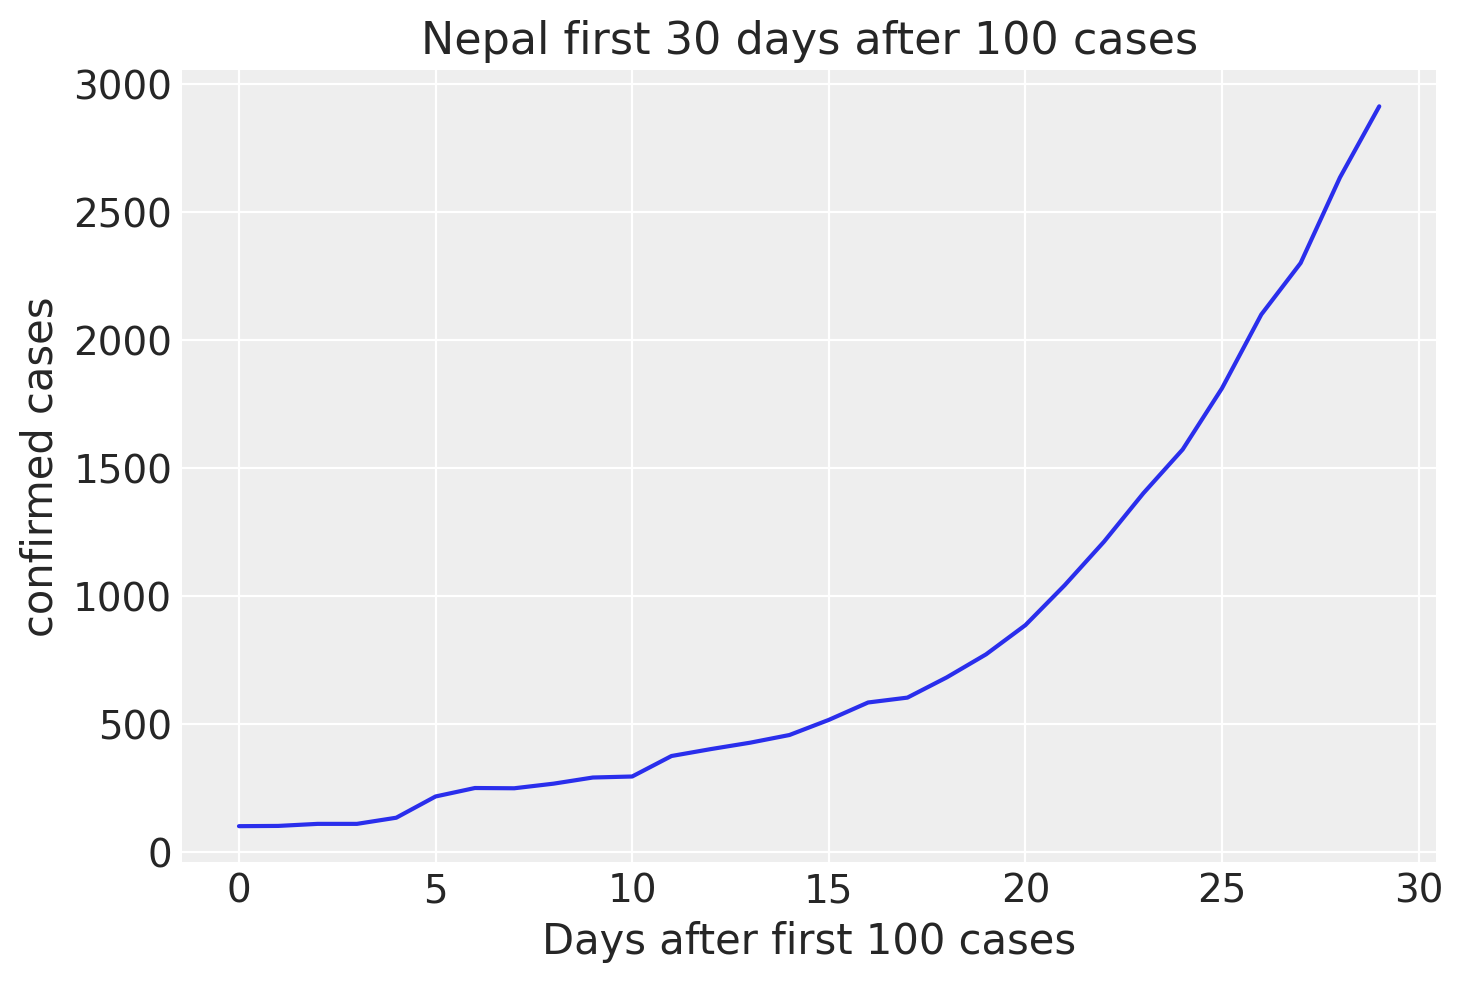

In [20]:
country='Nepal'
df_country=df.loc[df['country']==country].iloc[:30]

plt.plot(df_country['days_since_100'],df_country['confirmed'])
plt.title('Nepal first 30 days after 100 cases')
plt.xlabel('Days after first 100 cases')
plt.ylabel('confirmed cases')

In [21]:
t=df_country.days_since_100.values
confirmed=df_country.confirmed.values
## modelling covid
with pm.Model() as m4_1:
  a=pm.Normal('a',0,100)
  b=pm.Normal('b',0.3,0.1)
  sigma=pm.HalfNormal('sigma',100)
  growth_mu=pm.Deterministic('growth_mu', a * (1 + b)**t)

  cases=pm.Normal('cases',mu=growth_mu,sigma=sigma,observed=confirmed)

In [22]:
prior_m41=pm.sample_prior_predictive(100,m4_1)

[(-1000.0, 1000.0), Text(0, 0.5, 'cases'), (0.0, 10.0), Text(0.5, 0, 'Days')]

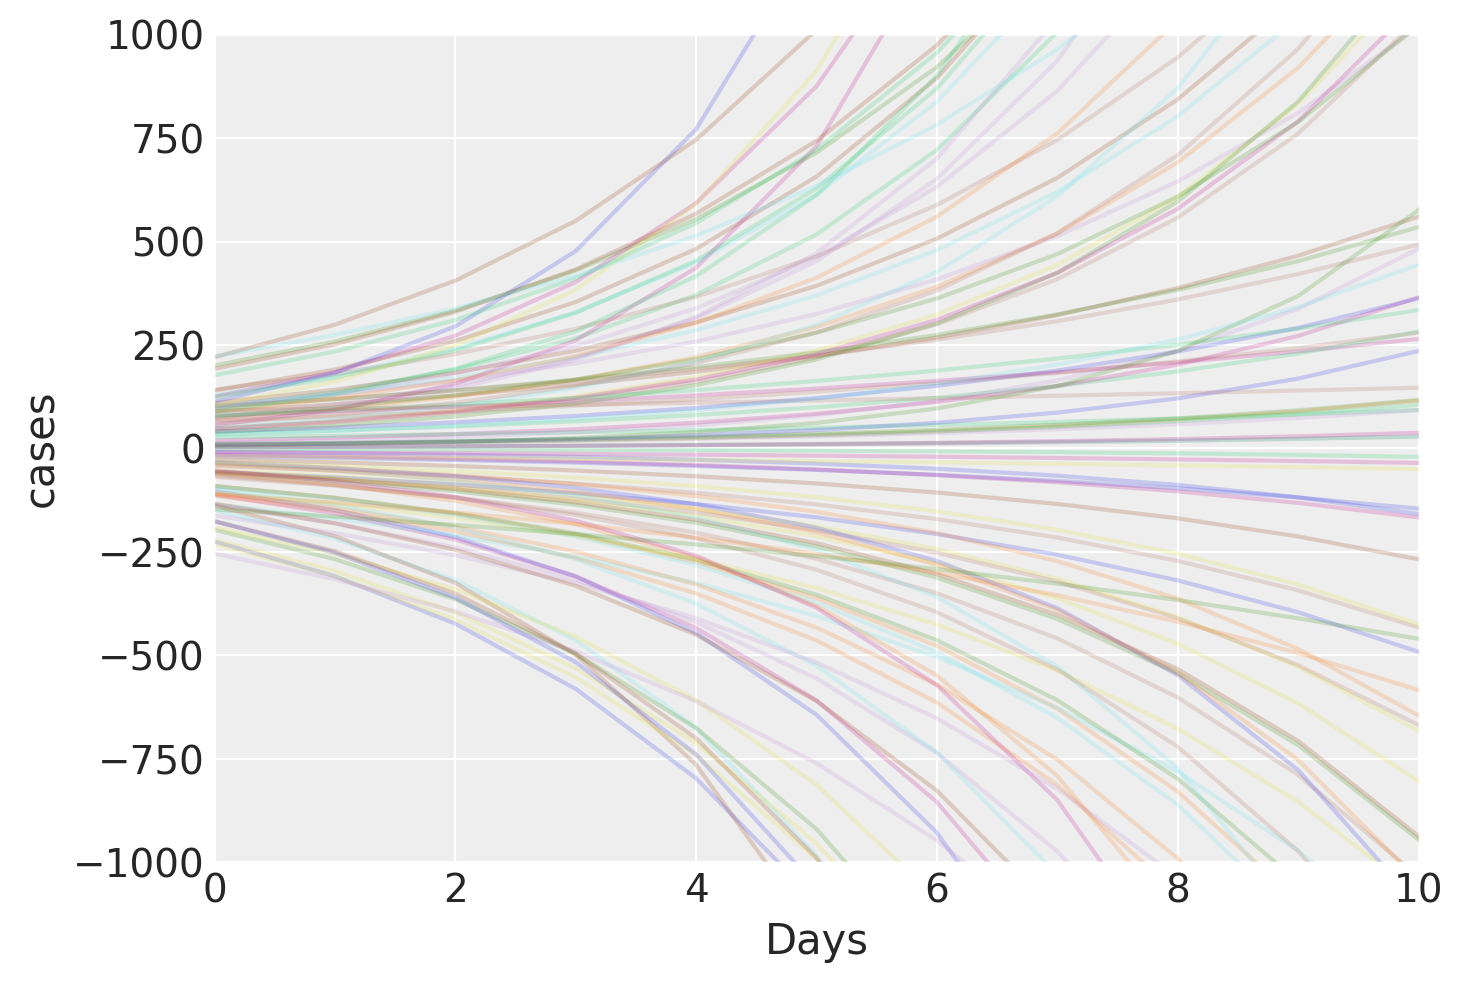

In [23]:
fig,ax=plt.subplots()
ax.plot(prior_m41['growth_mu'].T,alpha=0.2)
ax.set(xlabel='Days',ylabel='cases',ylim=(-1000,1000),xlim=(0,10))

In [24]:
with m4_1:
  trace4_1=pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


TypeError: ignored

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  UserWarning,


ValueError: ignored

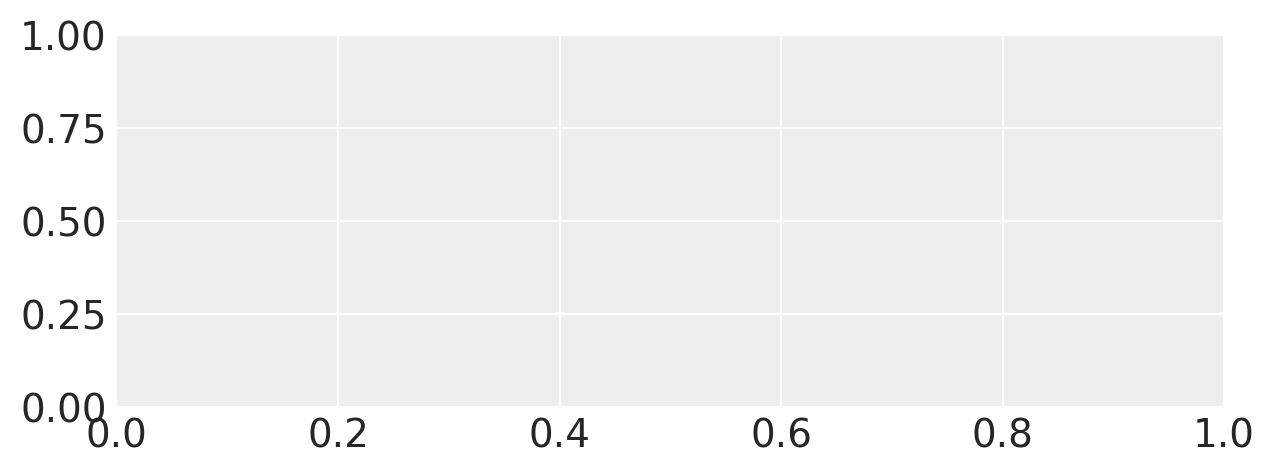

In [15]:
az.plot_trace(trace4_1)